Data from [High-throughput total RNA sequencing in single cells using VASA-seq.](https://doi.org/10.1038/s41587-022-01361-8)

In [1]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

# Data Loading

In [3]:
# adata = anndata.read_h5ad("../data/cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
DATA_FOLDER = "../../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER}cellcycle_maxine/different_cell_types/phase_VASA.h5ad"
)
adata

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 42063 × 16494
    obs: 'Cell_ID', 'obs_names', 'Stage', 'Dataset', 'G0?', 'UMAP_phase', 'UMI_SUM'
    var: 'var_names', 'Type'
    layers: 'matrix', 'spliced', 'unspliced'

In [4]:
annotation = pd.read_csv(
    f"{DATA_FOLDER}cellcycle_maxine/different_cell_types/umap_LeidenSphaseCelltype_vasa.tsv",
    sep="\t",
    index_col=0,
)
annotation = annotation.reset_index()
annotation["index"].str.split("-").str[0]
annotation["index"] = (
    annotation["index"].str.split("-").str[-1]
    + "_"
    + annotation["index"].str.split("-").str[0]
    + "-"
    + annotation["index"].str.split("-").str[1]
)
annotation = annotation.set_index("index")
annotation

umap1      umap2 batch  leiden  S-phase  \
index                                                                      
AAACGATCCTTACGGG_E6.5-3_i29  12.206623   0.891223  E6.5      29     True   
AAACTGTGCTCTTGAC_E6.5-3_i29  11.330956   0.654213  E6.5      29     True   
AAACTGTGTAAGACGG_E6.5-3_i29   3.544345  -2.354121  E6.5      19    False   
AAATAGCACTTACTCC_E6.5-3_i29  12.215343   0.703546  E6.5      29     True   
AACAGAACTCTGTGGT_E6.5-3_i29  11.676294   0.633441  E6.5      29     True   
...                                ...        ...   ...     ...      ...   
TGTTATCACGGGTAGT_E9.5-4_i27  -0.351355  17.922290  E9.5      40     True   
TGTTATCAGAATACGC_E9.5-4_i27  16.066618   6.589938  E9.5       4    False   
TGTTATCAGCACCTCT_E9.5-4_i27  16.551199   0.646162  E9.5      20    False   
TGTTATCAGGGAACCT_E9.5-4_i27   8.503787  14.024274  E9.5       5     True   
TGTTATCATGCCTCAC_E9.5-4_i27  13.096477  20.212719  E9.5       1    False   

                                                                      Celltype  
index                                                                           
AAACGATCCTTACGGG_E6.5-3_i29                                    Epiblast (E6.5)  
AAACTGTGCTCTTGAC_E6.5-3_i29                                    Epiblast (E6.5)  
AAACTGTGTAAGACGG_E6.5-3_i29                                      Trophectoderm  
AAATAGCACTTACTCC_E6.5-3_i29                                    Epiblast (E6.5)  
AACAGAACTCTGTGGT_E6.5-3_i29                                    Epiblast (E6.5)  
...                                                                        ...  
TGTTATCACGGGTAGT_E9.5-4_i27                                 Mesodermal Unknown  
TGTTATCAGAATACGC_E9.5-4_i27                                    Caudal Epiblast  
TGTTATCAGCACCTCT_E9.5-4_i27                            Dorsal Surface Ectoderm  
TGTTATCAGGGAACCT_E9.5-4_i27  Lateral Plate Mesoderm/Intermediate Mesoderm P...  
TGTTATCATGCCTCAC_E9.5-4_i27                                            Somites  

[33662 rows x 6 columns]

In [5]:
adata.obs = adata.obs.merge(
    annotation[["S-phase", "Celltype"]], how="left", left_on="Cell_ID", right_index=True
)

In [6]:
adata.layers["spliced"] = adata.layers["spliced"].astype("uint16")
adata.layers["unspliced"] = adata.layers["unspliced"].astype("uint16")

In [7]:
adata = adata[:, ~adata.var_names.duplicated()].copy()

# Data Filtering

In [8]:
sc.pp.filter_genes(adata, min_cells=10)

In [9]:
# create a new layer copy of the spliced layer
adata.layers["s_norm"] = adata.layers["spliced"].copy()
adata.layers["u_norm"] = adata.layers["unspliced"].copy()

# normalize the spliced layer, adding layer option, indicates which layer we want to normalize
sc.pp.normalize_total(adata, target_sum=1e4, layer="s_norm")
sc.pp.normalize_total(adata, target_sum=1e4, layer="u_norm")

# copy the normalized layer to a new layer, s_log
adata.layers["s_log"] = adata.layers["s_norm"].copy()
adata.layers["u_log"] = adata.layers["u_norm"].copy()

# log transform the normalized layer
sc.pp.log1p(adata, layer="s_log")
sc.pp.log1p(adata, layer="u_log")
# add % unspliced to adata.obs
adata.obs["s_counts"] = adata.layers["spliced"].sum(axis=1)
adata.obs["u_counts"] = adata.layers["unspliced"].sum(axis=1)

adata.obs["percent_unspliced"] = adata.obs["u_counts"] / (
    adata.obs["u_counts"] + adata.obs["s_counts"]
)

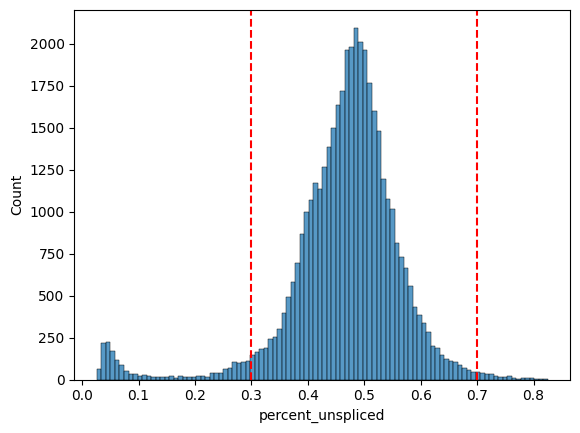

In [10]:
# plot distribution of % unspliced
sns.histplot(adata.obs["percent_unspliced"], bins=100)
# lower threshold for % unspliced
low_percent_unspliced = 0.3
# upper threshold for % unspliced
high_percent_unspliced = 0.7
plt.axvline(low_percent_unspliced, color="red", linestyle="--")
plt.axvline(high_percent_unspliced, color="red", linestyle="--")

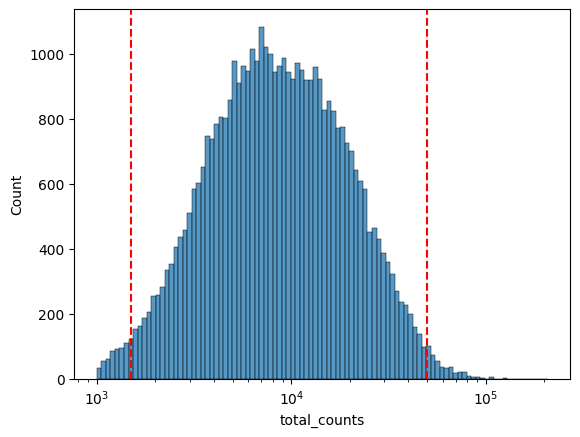

In [11]:
# add total counts to adata.obs
adata.obs["total_counts"] = adata.layers["spliced"].sum(
    axis=1
)  # + adata.layers["unspliced"].sum(axis=1)
# plot distribution of total counts
sns.histplot(adata.obs["total_counts"], bins=100, log_scale=True)
# lower threshold for total counts
low_total_counts = 1500
# upper threshold for total counts
high_total_counts = 50000
plt.axvline(low_total_counts, color="red", linestyle="--")
plt.axvline(high_total_counts, color="red", linestyle="--")

In [12]:
# filter cells based on thresholds
adata = adata[
    (adata.obs["percent_unspliced"] > low_percent_unspliced)
    & (adata.obs["percent_unspliced"] < high_percent_unspliced)
    & (adata.obs["total_counts"] > low_total_counts)
    & (adata.obs["total_counts"] < high_total_counts)
].copy()

In [13]:
adata.obs

Cell_ID  obs_names Stage      Dataset  G0?  \
0      AAACAAACAAAGCCTA_E8.5-19_i36          0  E8.5  E8.5-19_i36  0.0   
1       AAACAAACAAAGCCTA_E8.5-7_i20          1  E8.5   E8.5-7_i20  0.0   
2       AAACAAACAACAATCC_E9.5-6_i42          2  E9.5   E9.5-6_i42  0.0   
3       AAACAAACAACCCTTG_E8.5-2_i16          3  E8.5   E8.5-2_i16  0.0   
4       AAACAAACAACCCTTG_E9.5-4_i27          4  E9.5   E9.5-4_i27  0.0   
...                             ...        ...   ...          ...  ...   
46117   TGTTATCATTAGGACC_E9.5-5_i28      46117  E9.5   E9.5-5_i28  0.0   
46118   TGTTATCATTCCAGAC_E9.5-5_i28      46118  E9.5   E9.5-5_i28  0.0   
46120   TGTTATCATTGATCTA_E8.5-2_i16      46120  E8.5   E8.5-2_i16  0.0   
46121   TGTTATCATTGCATAT_E9.5-8_i44      46121  E9.5   E9.5-8_i44  0.0   
46123  TGTTATCATTGTCGCC_E8.5-16_i25      46123  E8.5  E8.5-16_i25  0.0   

       UMAP_phase  UMI_SUM S-phase                              Celltype  \
0        2.234725   3716.0     NaN                                   NaN   
1        4.659329   6066.0     NaN                                   NaN   
2        1.721789   6203.0    True               Intermediate Mesoderm I   
3        5.050425  26326.0     NaN                                   NaN   
4        2.447364   7234.0    True                     Paraxial Mesoderm   
...           ...      ...     ...                                   ...   
46117    6.099113  12009.0   False               Intermediate Mesoderm I   
46118    1.952546   8341.0    True                     Paraxial Mesoderm   
46120    6.067719   3548.0   False                               Somites   
46121    1.767173   4804.0     NaN                                   NaN   
46123    5.586664  22976.0    True  Spinal cord (differentiated neurons)   

       s_counts  u_counts  percent_unspliced  total_counts  
0          3714      4097           0.524517          3714  
1          6066      5598           0.479938          6066  
2          6203      5817           0.483943          6203  
3         26326     22491           0.460721         26326  
4          7233     10065           0.581859          7233  
...         ...       ...                ...           ...  
46117     12008     12064           0.501163         12008  
46118      8341      8797           0.513304          8341  
46120      3548      5096           0.589542          3548  
46121      4804      5316           0.525296          4804  
46123     22974     23334           0.503887         22974  

[38913 rows x 13 columns]

# PCA Derived Cell Cycle Phase Inference

In [14]:
adata.X = adata.layers["spliced"].copy()  # + adata.layers["unspliced"]

In [15]:
adata_all_genes = adata.copy()
layer_to_use = "spliced"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1

In [16]:
# Preprocess data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [17]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [18]:
len(SMALL_CYCLING_GENE_SET)

98

In [19]:
# mean center the adata
adata.X = adata.X - adata.X.mean(axis=1)

/tmp/ipykernel_366708/1782500935.py:2: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:636: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_366708/1782500935.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  sel

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


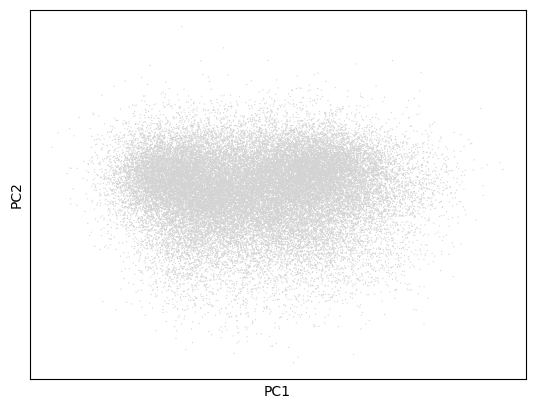

In [20]:
# pca on the data
sc.pp.pca(adata)
# plot the pca
sc.pl.pca(adata)

In [21]:
# add PCA theta to adata.obs
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 1], adata.obsm["X_pca"][:, 0]
)
adata_all_genes.obs["pca_theta"] = adata.obs["pca_theta"].copy()
adata = adata_all_genes.copy()

<Axes: ylabel='Frequency'>

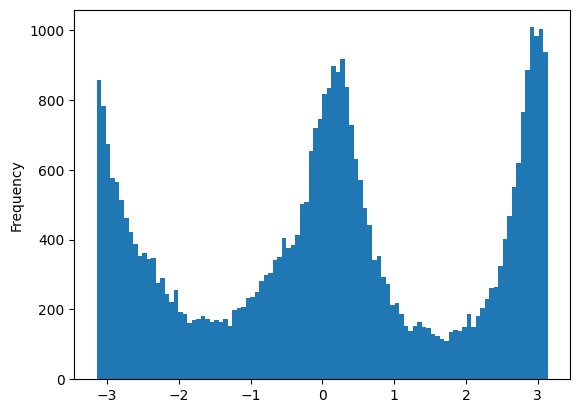

In [22]:
adata.obs["pca_theta"].plot.hist(bins=100)

# Model Set-Up and Training

In [23]:
# context genes
g = utils.get_variable_genes(adata)
len(g)

2000

Epoch 1/200, elbo_loss: 1823.8159, kl_div_f: 4.6812, kl_div_z: 38.9147, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -1.8920, entropy_loss: -94.6022, radial_variance: 2.0347, radius: 23.5222, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 1754.7705
Epoch 2/200, elbo_loss: 1491.3571, kl_div_f: 4.6289, kl_div_z: 41.7612, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.6116, entropy_loss: -130.5804, radial_variance: 3.0199, radius: 3.6636, L1_mu_z: 0.0000, MI_loss: 0.0002, total_loss: 1367.4713
Epoch 3/200, elbo_loss: 1412.2205, kl_div_f: 4.5669, kl_div_z: 41.8788, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.9819, entropy_loss: -149.0929, radial_variance: 2.4697, radius: 2.8114, L1_mu_z: 0.0000, MI_loss: 0.0020, total_loss: 1268.5084
Epoch 4/200, elbo_loss: 1373.8561, kl_div_f: 4.5019, kl_div_z: 42.0407, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3506, en

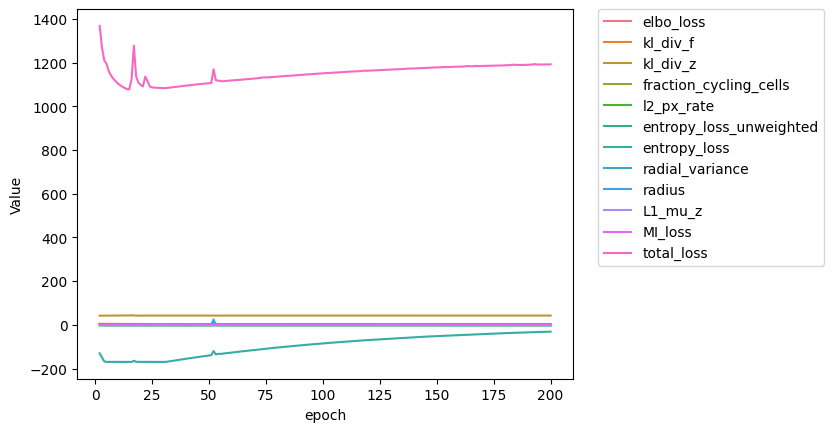

In [24]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
)
model.load_anndata(adata, layer_to_use="spliced")
trainer = Trainer(
    model,
    Loss.compute_loss,
    entropy_weight_factor=50,
    MI_weight=50,
    closed_circle_weight=10,
)
trainer.train_model(batch_size=2048)

# Results Extraction and Analysis

<Axes: ylabel='Count'>

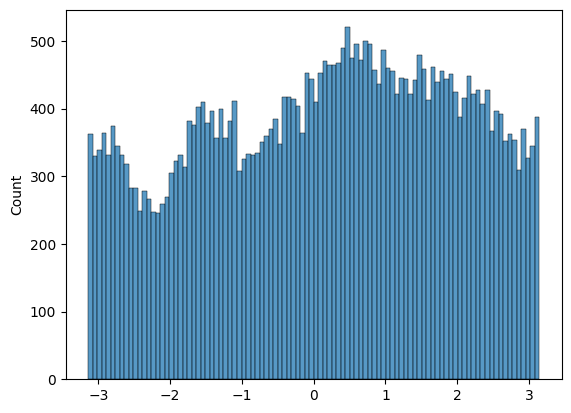

In [25]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()
sns.histplot(thetas, bins=100)

<Axes: >

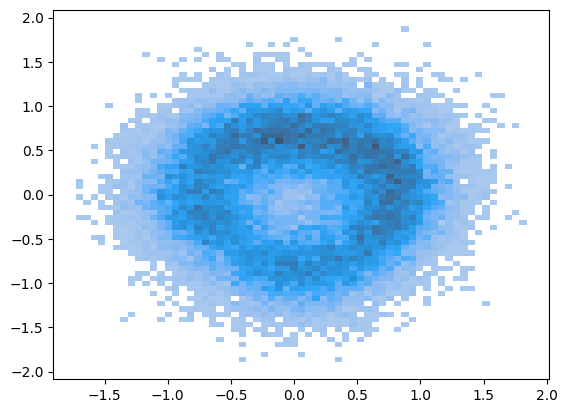

In [26]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(
    x=cells_projected[:, 0],
    y=cells_projected[:, 1],
)

## Align Inferred Phases Using the G1/S Transition (setting origin and direction)

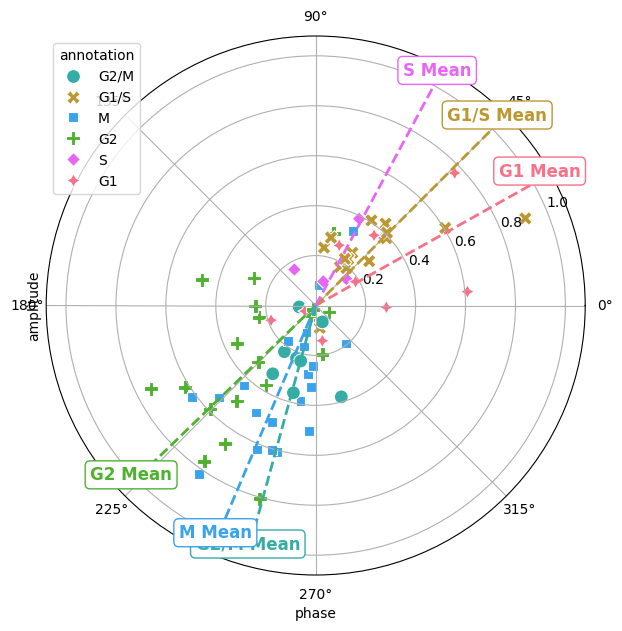

In [27]:
# thetas =
# plotting.modify_axis_labels()
# sns.histplot(thetas, bins=100)
thetas = model.infer_pseudotimes(adata, "spliced", True)
adata.obs["inferred_theta"] = thetas

## Analyzing the Results

In [28]:
adata.obs["inferred_theta"] = thetas
utils.get_jensenshannon(adata=adata, pseudotime_column="inferred_theta", hue="S-phase")

0.8224772013416933

In [29]:
plt.rcParams.update({"axes.titlesize": 18})
plt.rcParams.update({"legend.fontsize": 16})

<Axes: xlabel='inferred_theta', ylabel='pca_theta'>

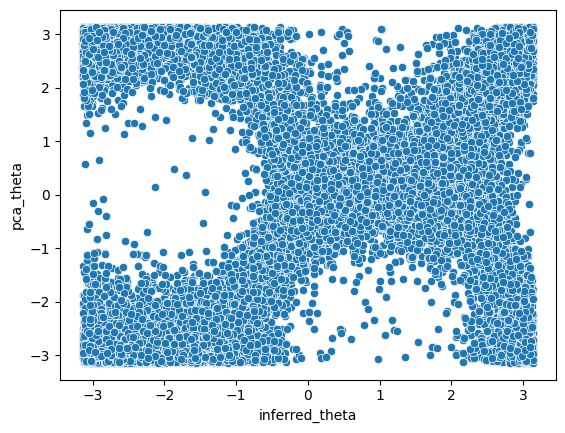

In [30]:
sns.scatterplot(
    x=adata.obs["inferred_theta"],
    y=utils.normalize_angles(adata.obs["pca_theta"] - np.pi),
)

In [31]:
def add_theta(df, theta, theta_pca):
    df["inferred_theta"] = theta
    df["pca_theta"] = theta_pca
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas, adata.obs["pca_theta"].values)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(df_rhythmic, thetas, adata.obs["pca_theta"].values)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas, adata.obs["pca_theta"].values)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


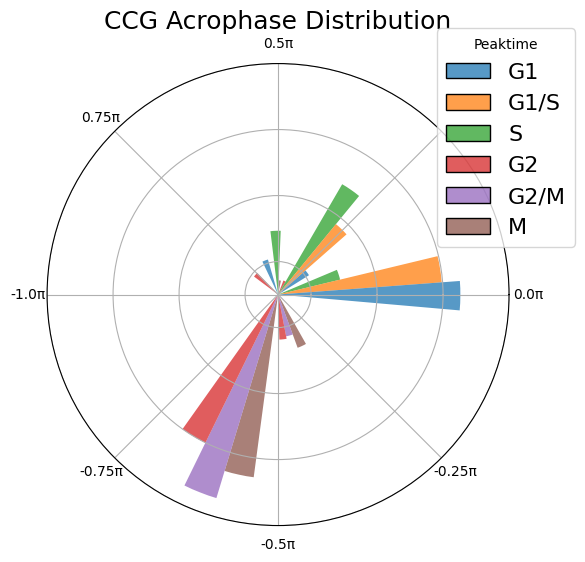

In [32]:
plotting.plot_cell_cycle(df_rhythmic)

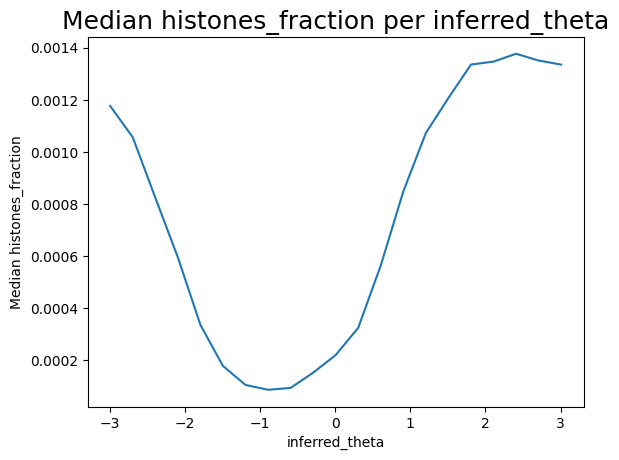

In [33]:
utils.add_histones_fraction(adata, layer="spliced", use_only_clustered=False)
plotting.plot_smoothed_size_evolution(
    adata, "inferred_theta", counts_sum_field="histones_fraction"
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


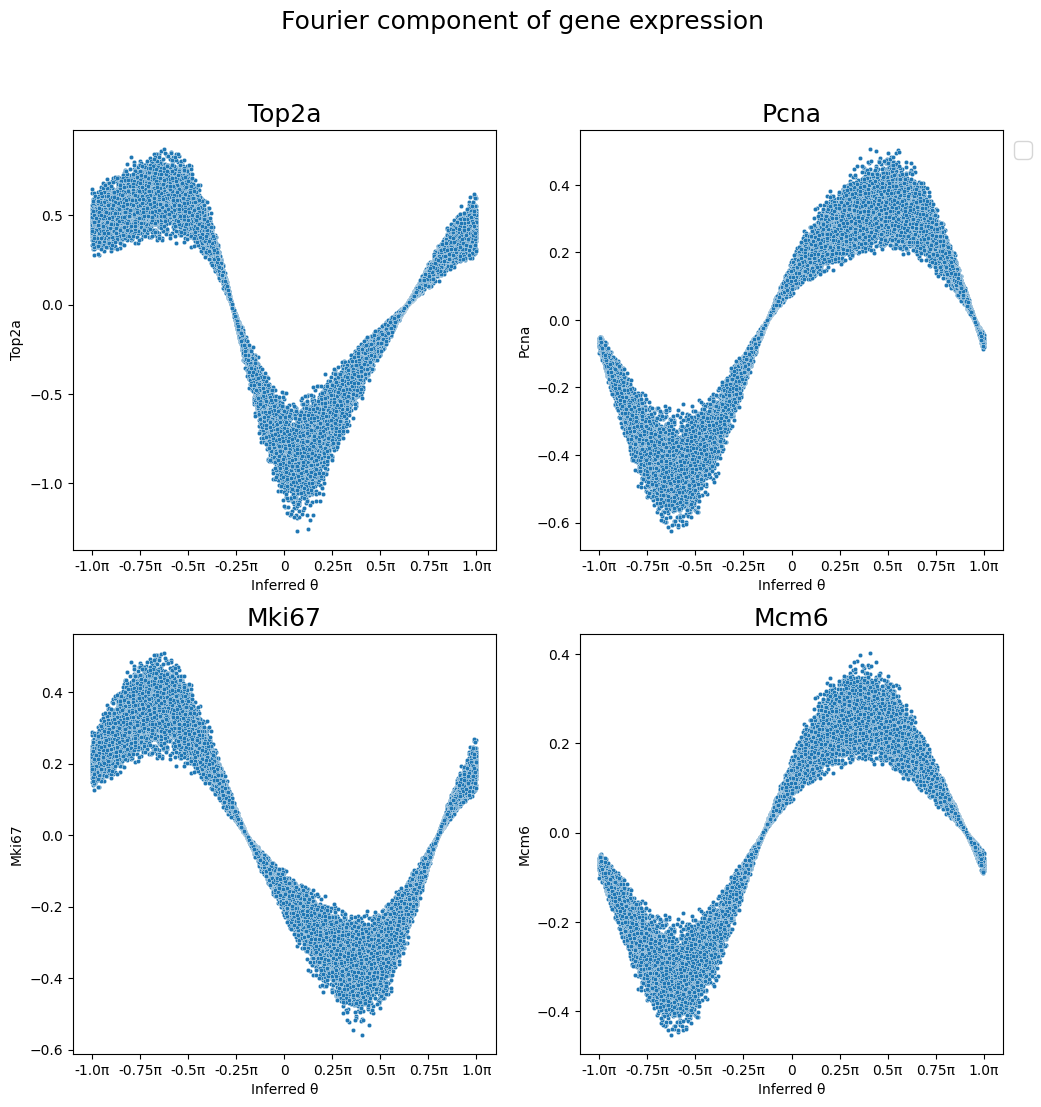

In [34]:
plotting.plot_model_decoded_space(
    df_rhythmic, "Fourier component of gene expression", gene_to_upper=False
)

In [35]:
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1

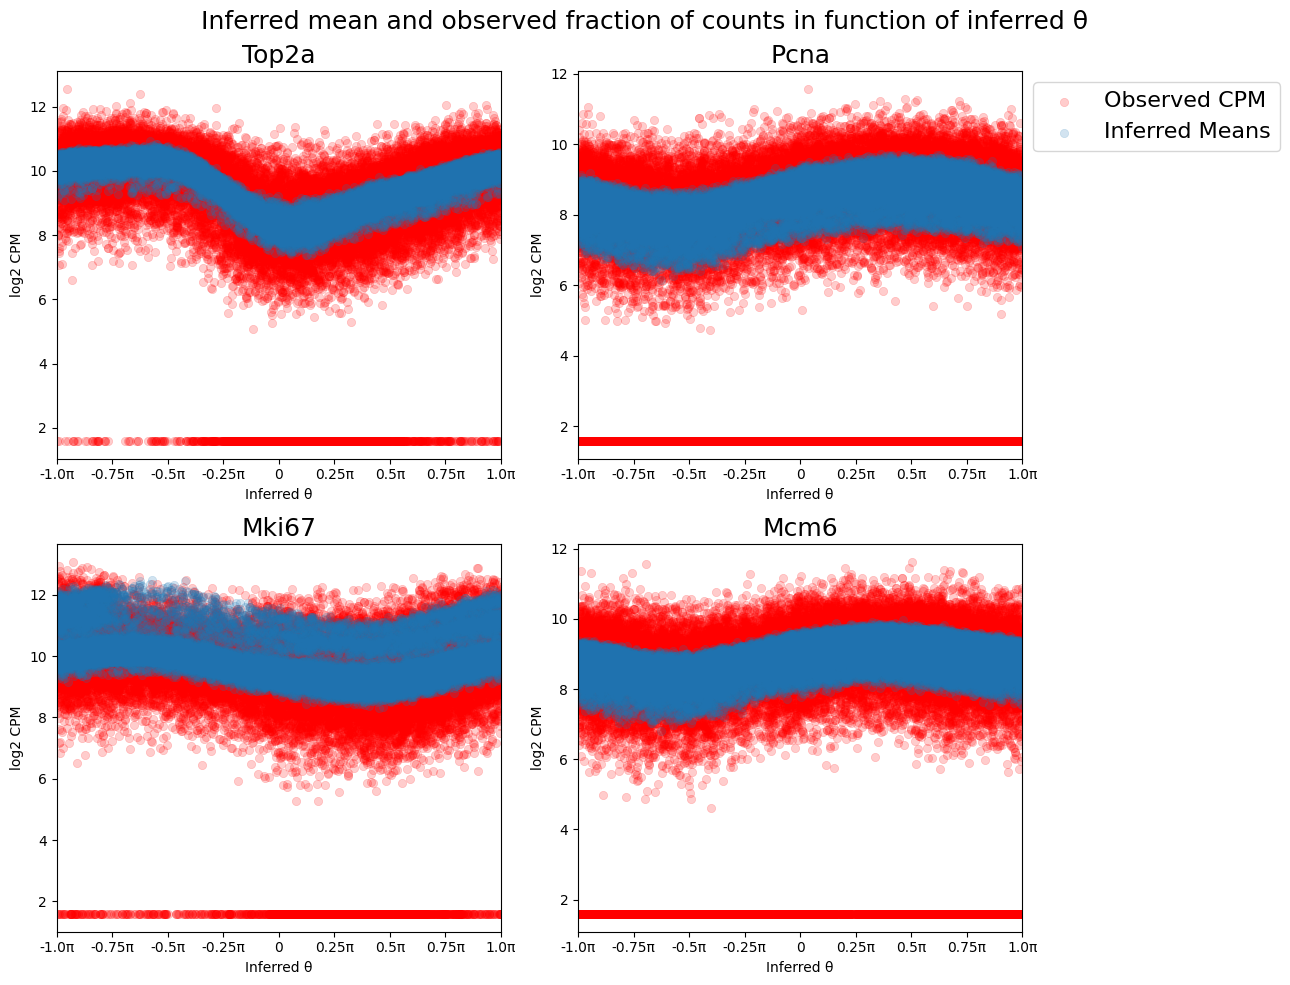

In [36]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    layer_to_use="spliced",
    library_size=library_size,
    gene_to_upper=False,
)

Erythropoietic cells seem to have higher MKi67 transcripts throughout the cell cycle

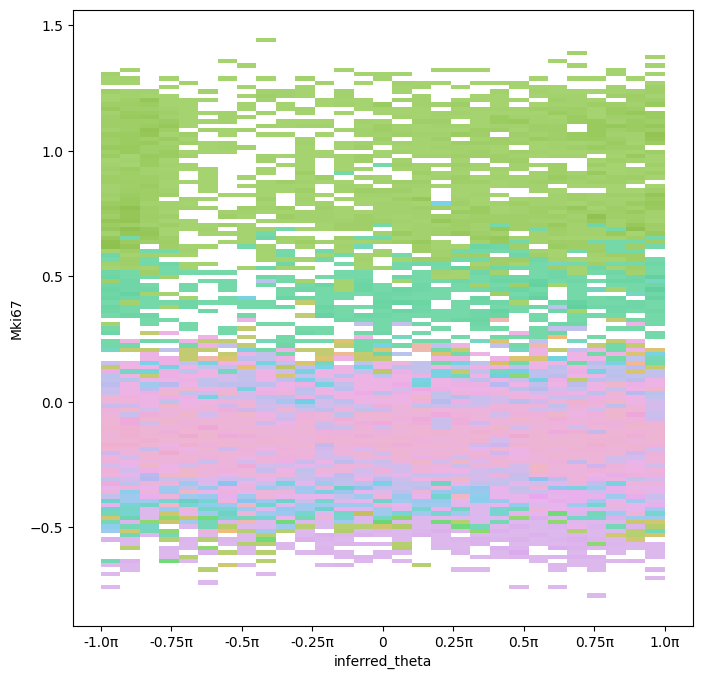

In [37]:
fig, axs = plotting.modify_axis_labels()
sns.histplot(
    data=df_z, x="inferred_theta", y="Mki67", hue=adata.obs["Celltype"].values, ax=axs
)
axs.get_legend().remove()

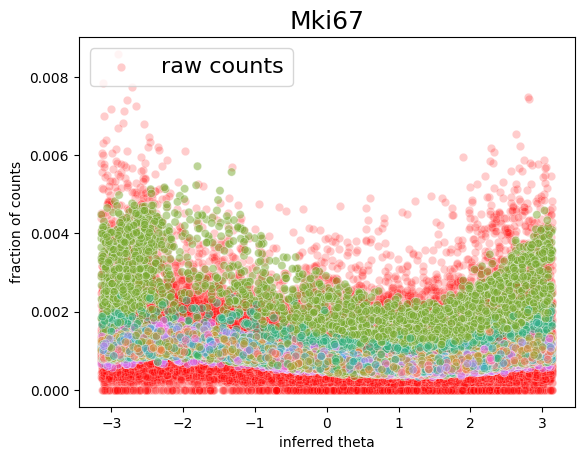

In [38]:
gene = "Mki67"
fig, ax1 = plt.subplots()
sns.scatterplot(
    x=df_mean["inferred_theta"],
    y=adata[:, gene].layers[layer_to_use].toarray().flatten() / library_size,
    alpha=0.2,
    label="raw counts",
    ax=ax1,
    color="red",
).set(ylabel="Raw counts")
sns.scatterplot(
    x=df_mean["inferred_theta"].values,
    y=df_mean[gene].values / library_size,
    alpha=0.5,
    hue=adata.obs["Celltype"].values,
    ax=ax1,
    legend=False,
).set(ylabel="Inferred mean")
ax1.legend(loc="upper left")
ax1.set_xlabel("inferred theta")
ax1.set_ylabel("fraction of counts")
plt.title(gene)
plt.show()

In [39]:
adata.obs["celltype_cat"] = adata.obs["Celltype"].apply(
    lambda x: (
        "erythropoietic" if x == "Erythropoiesis (expansive, S-phase)" else "other"
    )
)

([0, 1], [Text(0, 0, 'other'), Text(1, 0, 'erythropoietic')])

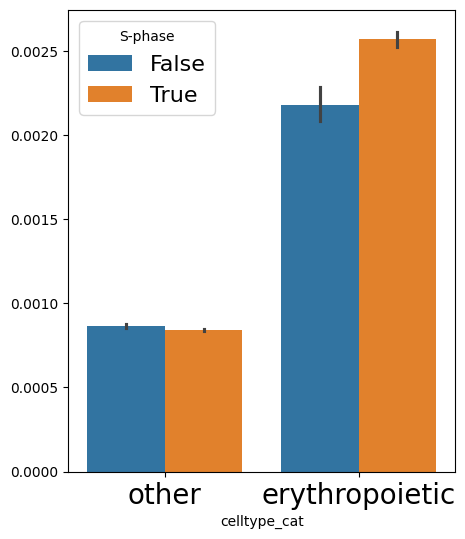

In [40]:
fix, ax = plt.subplots(figsize=(5, 6))
sns.barplot(
    x=adata.obs["celltype_cat"],
    y=adata[:, "Mki67"].layers["spliced"].todense().A1 / library_size,
    hue=adata.obs["S-phase"],
)
plt.xticks(fontsize=20)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


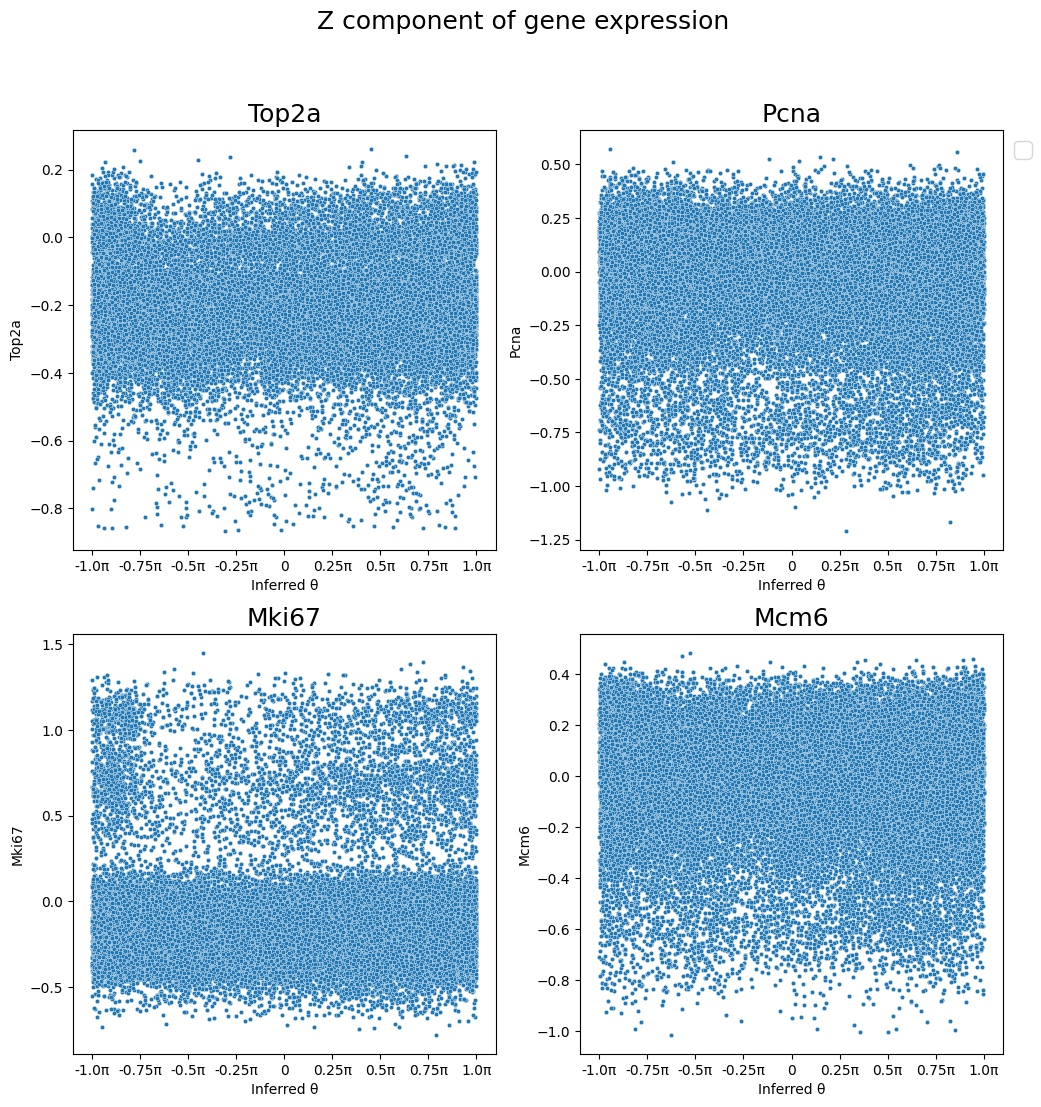

In [41]:
plotting.plot_model_decoded_space(
    df_z, "Z component of gene expression", gene_to_upper=False
)

In [42]:
adata.obs["library_size"] = library_size

Text(0.5, 1.0, 'Top2a')

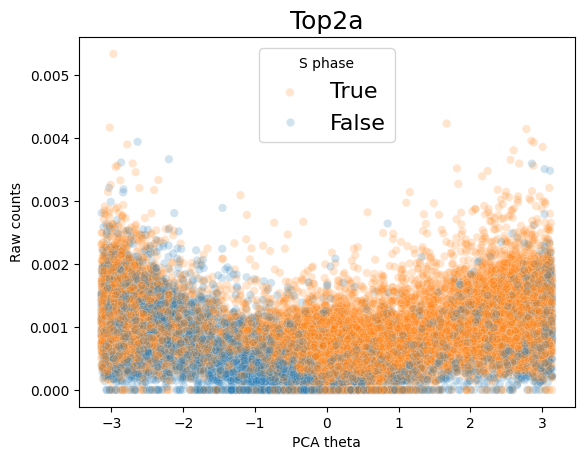

In [43]:
sns.scatterplot(
    x=utils.normalize_angles(adata.obs["pca_theta"] + np.pi),
    y=adata[:, "Top2a"].layers[layer_to_use].toarray().flatten() / library_size,
    alpha=0.2,
    hue=adata.obs["S-phase"].values,
).set(ylabel="Raw counts")
plt.legend(title="S phase", labels=["True", "False"])
plt.xlabel("PCA theta")
plt.title("Top2a")

Text(0.5, 1.0, 'TOP2a')

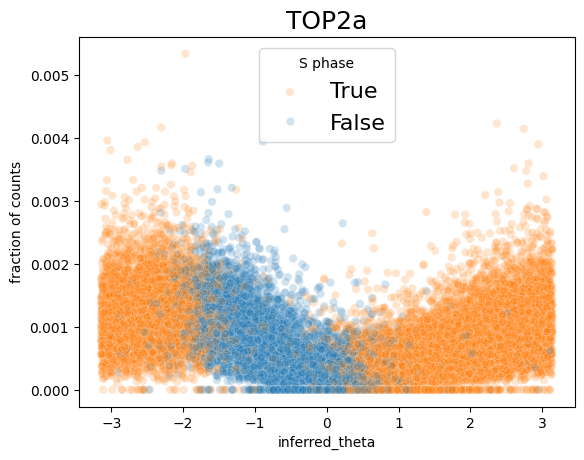

In [44]:
sns.scatterplot(
    x=df_mean["inferred_theta"],
    y=adata[:, "Top2a"].layers[layer_to_use].toarray().flatten() / library_size,
    hue=adata.obs["S-phase"].values,
    alpha=0.2,
).set(ylabel="fraction of counts")
plt.legend(title="S phase", labels=["True", "False"])
plt.title("TOP2a")

<Axes: xlabel='pca_theta', ylabel='Density'>

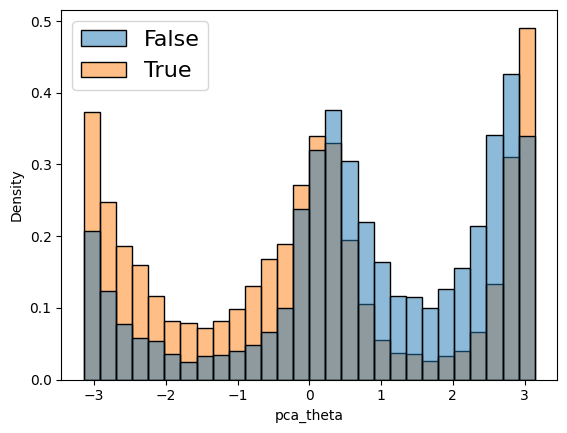

In [45]:
sns.histplot(
    x=adata.obs["pca_theta"],
    hue=adata.obs["S-phase"].values,
    stat="density",
    common_norm=False,
)

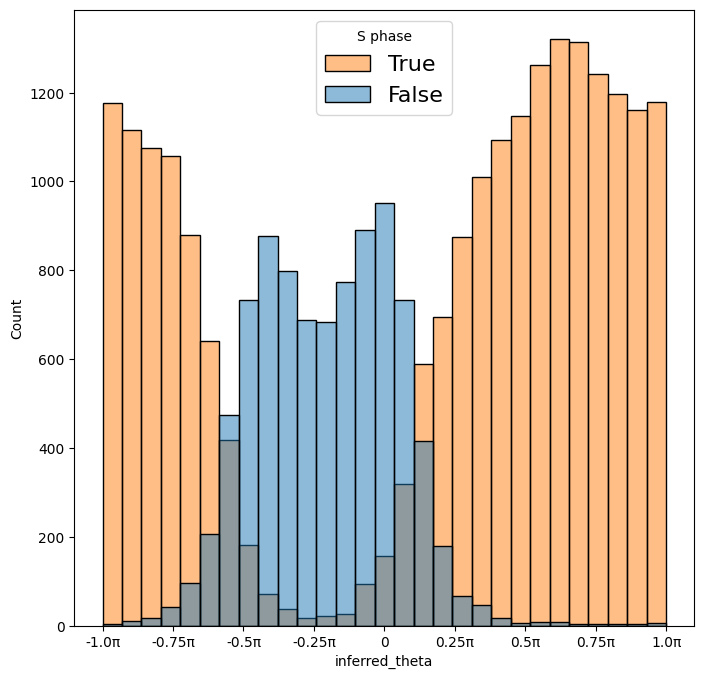

In [46]:
plotting.modify_axis_labels()
sns.histplot(x=df_mean["inferred_theta"], hue=adata.obs["S-phase"].values, legend=False)
plt.legend(title="S phase", labels=["True", "False"])

## z Space analysis

In [47]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(space_outputs["z"].numpy())

<Axes: >

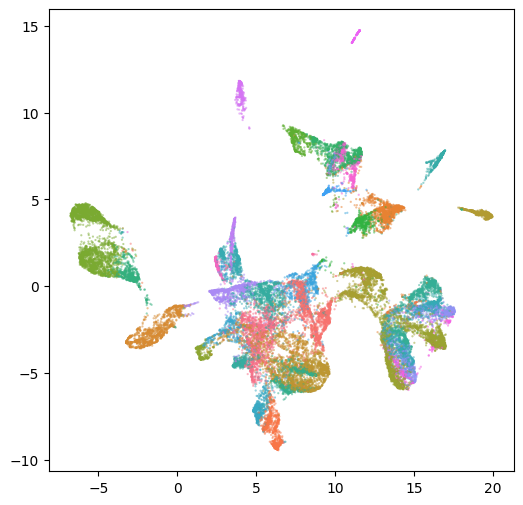

In [48]:
_, _ = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs["Celltype"],
    edgecolor=None,
    s=2,
    alpha=0.5,
    legend=False,
)

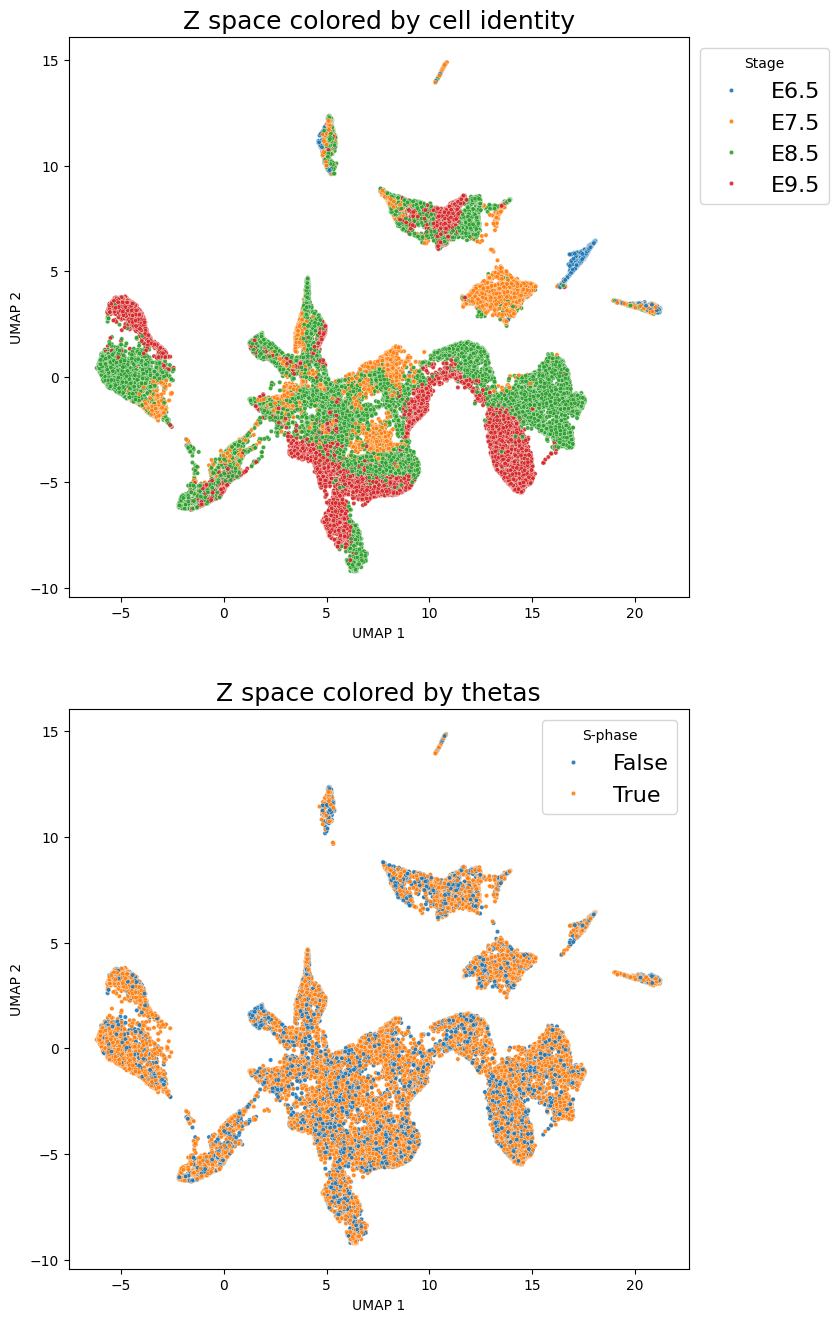

In [49]:
plotting.plot_z_space(space_outputs["z"], adata.obs["Stage"], adata.obs["S-phase"])

In [50]:
utils.get_jensenshannon(adata=adata, pseudotime_column="inferred_theta", hue="S-phase")

0.8224772013416933

In [51]:
utils.get_jensenshannon(adata=adata, pseudotime_column="pca_theta", hue="S-phase")

0.2960033872640497

In [52]:
# utils.get_jensenshannon(adata=adata,pseudotime_column="posterior_theta",hue="S-phase")

In [53]:
adata.obs["random\ntheta"] = np.random.uniform(-np.pi, np.pi, len(adata.obs))
utils.get_jensenshannon(adata=adata, pseudotime_column="random\ntheta", hue="S-phase")

0.029425546337095574

In [54]:
JS_res = {  # "posterior\n decoder":[utils.get_jensenshannon(adata=adata,pseudotime_column="posterior_theta",hue="S-phase")],
    "Our Method": [
        utils.get_jensenshannon(
            adata=adata, pseudotime_column="inferred_theta", hue="S-phase"
        )
    ],
    "PCA": [
        utils.get_jensenshannon(
            adata=adata, pseudotime_column="pca_theta", hue="S-phase"
        )
    ],
    # "PCA": [
    #     utils.get_jensenshannon(
    #         adata=adata, pseudotime_column="pca_theta", hue="S-phase"
    #     )
    # ],
    "Cyclop": [0.12634239067230416],
    "random": utils.get_jensenshannon(
        adata=adata, pseudotime_column="random\ntheta", hue="S-phase"
    ),
}

In [55]:
adata.obs["Celltype"] = adata.obs["Celltype"].astype(str)

In [56]:
# to_save = {
#     "embedding": embedding,
#     "phases": adata.obs["inferred_theta"],
#     "author_labels": adata.obs["S-phase"],
#     "JS_res": JS_res,
#     "f_space": cells_projected,
#     "df_rhythmic": df_rhythmic,
#     "df_mean": df_mean,
#     "df_z": df_z,
# }
# import pickle

# # with open("../data/vasa_res.pkl", "wb") as f:
# #     pickle.dump(to_save, f)

([0, 1, 2, 3],
 [Text(0, 0, 'Our Method'),
  Text(1, 0, 'PCA'),
  Text(2, 0, 'Cyclop'),
  Text(3, 0, 'random')])

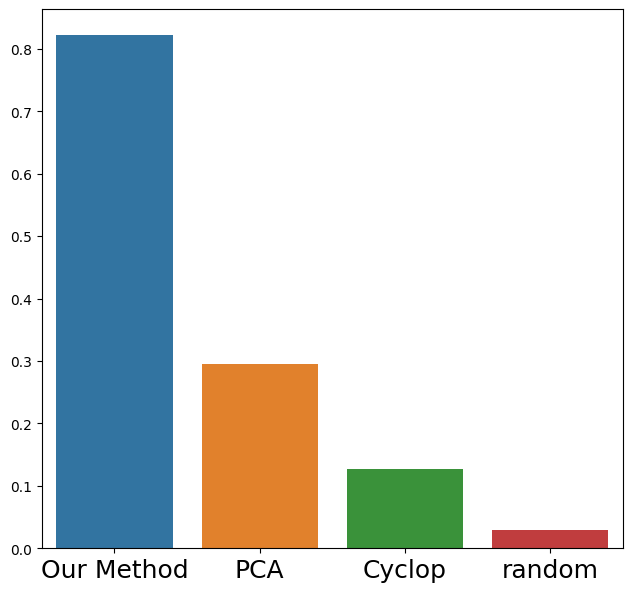

In [57]:
plt.subplots(figsize=(7.5, 7))
sns.barplot(pd.DataFrame(JS_res))
plt.xticks(fontsize=18)